<a href="https://colab.research.google.com/github/olgasem10/Compling-tasks/blob/master/Conv_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
quora = pd.read_csv('/content/drive/My Drive/quora.csv')

In [0]:
quora

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0
...,...,...,...
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0


In [0]:
def preprocess(text):
  characters = list(text)
  return characters

In [0]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
# индексируем символы
char2id = {'UNK':1, 'PAD':0}

for char in vocab:
    char2id[char] = len(char2id)

In [0]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    chars = preprocess(text)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [0]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [0]:
# ModelCheckpoint сохраняет лучшие версии моделей
checkpoint = tf.keras.callbacks.ModelCheckpoint('/content/drive/My Drive/CNN4/model4.weights', # названия файла 
                                                monitor='val_f1', # за какой метрикой следить
                                                verbose=1, # будет печатать что происходит
                                                save_weights_only=True, # если нужно только веса сохранить
                                                save_best_only=True, # сохранять только лучшие
                                                mode='max', # если метрика должна расти, то тут max и min если наоборот
                                                save_freq='epoch' # как часто вызывать
                                               )

# EarlyStopping позволяет автоматически остановить обучение, если качество не улучшается 
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_f1', 
                                              min_delta=0.01, # какая разница считается как улучшение
                                              patience=3, # сколько эпох терпеть отсутствие улучшений
                                              verbose=1, 
                                              mode='max',
                                              )

## Лучшая модель

In [0]:
inputs = tf.keras.layers.Input(shape=(100,), name='inputs')
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=10, name='embeddings')(inputs, )

pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [54,54], [0, 0]], 
                                               mode='REFLECT'), name='pad1')(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=16, strides = 2, name='conv1')(pad1)

drop1 = tf.keras.layers.Dropout(0.3, name='drop1')(conv1)

conv2 = tf.keras.layers.Conv1D(kernel_size=20, filters=32, strides = 2, name='conv2')(drop1)

pool1 = tf.keras.layers.MaxPool1D()(conv2)



drop2 = tf.keras.layers.Dropout(0.2, name = 'drop2')(embeddings)

pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [64,64], [0, 0]], 
                                               mode='SYMMETRIC'), name='pad2')(drop2)
conv3 = tf.keras.layers.Conv1D(kernel_size=30, filters=32, strides = 2, name='conv3')(pad2)

pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [64,64], [0, 0]], 
                                               mode='REFLECT'), name='pad3')(conv3)

conv4 = tf.keras.layers.Conv1D(kernel_size=40, filters=64, strides = 6, name='conv4')(pad3)

pool2 = tf.keras.layers.MaxPool1D(pool_size=13, strides = 1, name='pool2')(conv4)



pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [66,66], [0, 0]], 
                                               mode='REFLECT'), name='pad4')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=20, filters=8, strides = 2, name='conv5')(pad4)

pool3 = tf.keras.layers.MaxPool1D(strides=1, name='pool3')(conv5)

drop3 = tf.keras.layers.Dropout(0.1, name = 'drop3')(pool3)

conv6 = tf.keras.layers.Conv1D(kernel_size=30, filters=16, strides = 4, name='conv6')(drop3)


concat = tf.keras.layers.concatenate([pool1, pool2, conv6], name='concat')
dense = tf.keras.layers.Dense(64, activation='relu', name='dense')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(dense)

model6 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model6.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [0]:
model6.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 100)]        0                                            
__________________________________________________________________________________________________
embeddings (Embedding)          (None, 100, 10)      20490       inputs[0][0]                     
__________________________________________________________________________________________________
drop2 (Dropout)                 (None, 100, 10)      0           embeddings[0][0]                 
__________________________________________________________________________________________________
pad1 (Lambda)                   (None, 208, 10)      0           embeddings[0][0]                 
______________________________________________________________________________________________

In [0]:
model6.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=10,
          callbacks=[checkpoint, early_stop])

Epoch 1/10
249/249 [==============================] - ETA: 0s - loss: 0.2300 - f1: 0.0025
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to /content/drive/My Drive/CNN2/model6.weights
249/249 [==============================] - 1417s 6s/step - loss: 0.2300 - f1: 0.0025 - val_loss: 0.2079 - val_f1: 0.0000e+00
Epoch 2/10
249/249 [==============================] - ETA: 0s - loss: 0.2052 - f1: 0.0020
Epoch 00002: val_f1 improved from 0.00000 to 0.00049, saving model to /content/drive/My Drive/CNN2/model6.weights
249/249 [==============================] - 1405s 6s/step - loss: 0.2052 - f1: 0.0020 - val_loss: 0.1994 - val_f1: 4.9261e-04
Epoch 3/10
249/249 [==============================] - ETA: 0s - loss: 0.1973 - f1: 0.0859
Epoch 00003: val_f1 improved from 0.00049 to 0.08473, saving model to /content/drive/My Drive/CNN2/model6.weights
249/249 [==============================] - 1409s 6s/step - loss: 0.1973 - f1: 0.0859 - val_loss: 0.1932 - val_f1: 0.0847
Epoch 4/10
249/249 [

dict_keys(['loss', 'f1', 'val_loss', 'val_f1'])


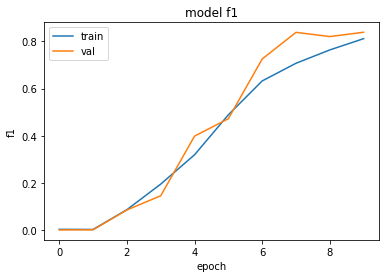

In [0]:
print(model6.history.history.keys())
plt.plot(model6.history.history['f1'])
plt.plot(model6.history.history['val_f1'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Тексты приведены к нижнему регистру

In [0]:
def preprocess(text):
  characters = list(text.lower())
  return characters

In [0]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
# индексируем символы
char2id = {'UNK':1, 'PAD':0}

for char in vocab:
    char2id[char] = len(char2id)

In [0]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    chars = preprocess(text)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [0]:
inputs = tf.keras.layers.Input(shape=(100,), name='inputs')
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=10, name='embeddings')(inputs, )

pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [54,54], [0, 0]], 
                                               mode='REFLECT'), name='pad1')(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=16, strides = 2, name='conv1')(pad1)

drop1 = tf.keras.layers.Dropout(0.3, name='drop1')(conv1)

conv2 = tf.keras.layers.Conv1D(kernel_size=20, filters=32, strides = 2, name='conv2')(drop1)

pool1 = tf.keras.layers.MaxPool1D()(conv2)



drop2 = tf.keras.layers.Dropout(0.2, name = 'drop2')(embeddings)

pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [64,64], [0, 0]], 
                                               mode='SYMMETRIC'), name='pad2')(drop2)
conv3 = tf.keras.layers.Conv1D(kernel_size=30, filters=32, strides = 2, name='conv3')(pad2)

pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [64,64], [0, 0]], 
                                               mode='REFLECT'), name='pad3')(conv3)

conv4 = tf.keras.layers.Conv1D(kernel_size=40, filters=64, strides = 6, name='conv4')(pad3)

pool2 = tf.keras.layers.MaxPool1D(pool_size=13, strides = 1, name='pool2')(conv4)



pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [66,66], [0, 0]], 
                                               mode='REFLECT'), name='pad4')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=20, filters=8, strides = 2, name='conv5')(pad4)

pool3 = tf.keras.layers.MaxPool1D(strides=1, name='pool3')(conv5)

drop3 = tf.keras.layers.Dropout(0.1, name = 'drop3')(pool3)

conv6 = tf.keras.layers.Conv1D(kernel_size=30, filters=16, strides = 4, name='conv6')(drop3)


concat = tf.keras.layers.concatenate([pool1, pool2, conv6], name='concat')
dense = tf.keras.layers.Dense(64, activation='relu', name='dense')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(dense)

model7 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model7.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [0]:
model7.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=5,
          callbacks=[checkpoint, early_stop])

Epoch 1/5
249/249 [==============================] - ETA: 0s - loss: 0.2280 - f1: 0.0000e+00
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to /content/drive/My Drive/CNN2/model7.weights
249/249 [==============================] - 1395s 6s/step - loss: 0.2280 - f1: 0.0000e+00 - val_loss: 0.2112 - val_f1: 0.0000e+00
Epoch 2/5
249/249 [==============================] - ETA: 0s - loss: 0.2067 - f1: 0.0251
Epoch 00002: val_f1 improved from 0.00000 to 0.03165, saving model to /content/drive/My Drive/CNN2/model7.weights
249/249 [==============================] - 1399s 6s/step - loss: 0.2067 - f1: 0.0251 - val_loss: 0.1999 - val_f1: 0.0316
Epoch 3/5
249/249 [==============================] - ETA: 0s - loss: 0.1984 - f1: 0.0777
Epoch 00003: val_f1 improved from 0.03165 to 0.07842, saving model to /content/drive/My Drive/CNN2/model7.weights
249/249 [==============================] - 1397s 6s/step - loss: 0.1984 - f1: 0.0777 - val_loss: 0.1946 - val_f1: 0.0784
Epoch 4/5
249/249 [

## Оставлены только пробелы и буквы английского алфавита

In [0]:
def preprocess(text):
  characters = list(text.lower())
  characters = [char for char in characters if char.isalpha() or char == ' ']
  return characters

In [0]:
# словарь
vocab = Counter()

for text in quora.question_text:
    vocab.update(preprocess(text))

In [0]:
# отфильтрованный словарь
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 600:
        filtered_vocab.add(word)

len(filtered_vocab)

28

In [0]:
# индексируем символы
char2id = {'UNK':1, 'PAD':0}

for char in filtered_vocab:
    char2id[char] = len(char2id)

In [0]:
# переводим тексты в последовательности индексов
X = []

for text in quora.question_text:
    chars = preprocess(text)
    ids = [char2id.get(char, 1) for char in chars]
    X.append(ids)

In [0]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=100)

In [0]:
y = quora.target.values

In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, random_state=42, stratify=y)

In [0]:
inputs = tf.keras.layers.Input(shape=(100,), name='inputs')
embeddings = tf.keras.layers.Embedding(input_dim=len(char2id), output_dim=10, name='embeddings')(inputs, )

pad1 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [54,54], [0, 0]], 
                                               mode='REFLECT'), name='pad1')(embeddings)
conv1 = tf.keras.layers.Conv1D(kernel_size=10, filters=16, strides = 2, name='conv1')(pad1)

drop1 = tf.keras.layers.Dropout(0.3, name='drop1')(conv1)

conv2 = tf.keras.layers.Conv1D(kernel_size=20, filters=32, strides = 2, name='conv2')(drop1)

pool1 = tf.keras.layers.MaxPool1D()(conv2)



drop2 = tf.keras.layers.Dropout(0.2, name = 'drop2')(embeddings)

pad2 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [64,64], [0, 0]], 
                                               mode='SYMMETRIC'), name='pad2')(drop2)
conv3 = tf.keras.layers.Conv1D(kernel_size=30, filters=32, strides = 2, name='conv3')(pad2)

pad3 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [64,64], [0, 0]], 
                                               mode='REFLECT'), name='pad3')(conv3)

conv4 = tf.keras.layers.Conv1D(kernel_size=40, filters=64, strides = 6, name='conv4')(pad3)

pool2 = tf.keras.layers.MaxPool1D(pool_size=13, strides = 1, name='pool2')(conv4)



pad4 = tf.keras.layers.Lambda(lambda x: tf.pad(x, 
                                               [[0,0], [66,66], [0, 0]], 
                                               mode='REFLECT'), name='pad4')(embeddings)
conv5 = tf.keras.layers.Conv1D(kernel_size=20, filters=8, strides = 2, name='conv5')(pad4)

pool3 = tf.keras.layers.MaxPool1D(strides=1, name='pool3')(conv5)

drop3 = tf.keras.layers.Dropout(0.1, name = 'drop3')(pool3)

conv6 = tf.keras.layers.Conv1D(kernel_size=30, filters=16, strides = 4, name='conv6')(drop3)


concat = tf.keras.layers.concatenate([pool1, pool2, conv6], name='concat')
dense = tf.keras.layers.Dense(64, activation='relu', name='dense')(concat)
outputs = tf.keras.layers.Dense(1, activation='sigmoid', name='outputs')(dense)

model8 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model8.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[f1])

In [0]:
model8.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=5000,
         epochs=5,
          callbacks=[checkpoint, early_stop])

Epoch 1/5
249/249 [==============================] - ETA: 0s - loss: 0.2324 - f1: 0.0018
Epoch 00001: val_f1 improved from -inf to 0.00000, saving model to /content/drive/My Drive/CNN3/model8.weights
249/249 [==============================] - 1442s 6s/step - loss: 0.2324 - f1: 0.0018 - val_loss: 0.2140 - val_f1: 0.0000e+00
Epoch 2/5
249/249 [==============================] - ETA: 0s - loss: 0.2094 - f1: 0.0019
Epoch 00002: val_f1 improved from 0.00000 to 0.00784, saving model to /content/drive/My Drive/CNN3/model8.weights
249/249 [==============================] - 1433s 6s/step - loss: 0.2094 - f1: 0.0019 - val_loss: 0.2092 - val_f1: 0.0078
Epoch 3/5
249/249 [==============================] - ETA: 0s - loss: 0.2018 - f1: 0.0134
Epoch 00003: val_f1 did not improve from 0.00784
249/249 [==============================] - 1439s 6s/step - loss: 0.2018 - f1: 0.0134 - val_loss: 0.1981 - val_f1: 0.0013
Epoch 4/5
249/249 [==============================] - ETA: 0s - loss: 0.1975 - f1: 0.0587
Epo